```
[pre-works]
```
compare with open source code of [cheind](https://github.com/cheind/mingru)
to check my code

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 128

EMBEDDING_DIM = SEQUENCE_LENGTH
HIDDEN_DIM = EMBEDDING_DIM*2

BATCH_SIZE = 512
EPOCHS = 10
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

NUM_LAYERS = 3
NUM_HEADS = 4
FFN_DIM = SEQUENCE_LENGTH
DROPOUT = 0.1

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:1


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('../data/input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003727
Validation dataset size: 111411


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([512, 128])
Target shape: torch.Size([512, 128])
Sample 1: ------------------------------
Input sequence : nce's point,That it may enter Mowbray's waxen coat,And furbish new the name of John a Gaunt,Even in the lusty havior of his s
Target sequence: ce's point,That it may enter Mowbray's waxen coat,And furbish new the name of John a Gaunt,Even in the lusty havior of his so

Sample 2: ------------------------------
Input sequence : TESBY:He will do all in all as Hastings doth.BUCKINGHAM:Well, then, no more but this: go, gentle Catesby,And, as it were fa
Target sequence: ESBY:He will do all in all as Hastings doth.BUCKINGHAM:Well, then, no more but this: go, gentle Catesby,And, as it were far

Sample 3: ------------------------------
Input sequence :  have I spill'd; O would the deed were good!For now the devil, that told me I did well,Says that this deed is chronicled in he
Target sequence: have I spill'd; O would the deed were good!For now the devil, that told m

## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [17]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [18]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])

In [19]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

In [20]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [21]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, fused=True)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

## mingru

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math # math.log 및 상수 사용을 위함
from tqdm import tqdm # tqdm 임포트 추가

# Lion 옵티마이저 임포트 (설치 필요: pip install lion-pytorch)
# from lion_pytorch import Lion # 주석 처리 - 실제 사용 시 주석 해제

def log_g(x: torch.Tensor) -> torch.Tensor:
    """
    은닉 상태 후보를 로그 공간으로 변환하는 함수.
    x >= 0 이면 log(x + 0.5)
    x < 0 이면 log(sigmoid(x))
    """
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))

def parallel_scan_log(log_coeffs: torch.Tensor, log_values: torch.Tensor) -> torch.Tensor:
    """
    로그 공간에서 병렬 스캔 연산을 수행합니다. (클램핑 제거됨)
    Args:
        log_coeffs (torch.Tensor): [B, L, H_internal] 형태의 텐서로, log(alpha_t)를 나타냅니다.
        log_values (torch.Tensor): [B, L+1, H_internal] 형태의 텐서로, [log_h_initial, log(beta_1), ..., log(beta_L)]를 나타냅니다.
    Returns:
        torch.Tensor: [B, L, H_internal] 형태의 텐서로, 지수 함수가 적용된 은닉 상태 (h_1 부터 h_L까지)를 나타냅니다.
    """
    log_proda_coeffs_prefix = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0), value=0.0)
    terms_for_logcumsumexp = log_values - log_proda_coeffs_prefix
    log_sum_exp_terms = torch.logcumsumexp(terms_for_logcumsumexp, dim=1) 
    log_hidden_states = log_proda_coeffs_prefix + log_sum_exp_terms
    output_hidden_states = torch.exp(log_hidden_states[:, 1:, :]) 
    return output_hidden_states

class ParallelLogMinGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, expansion_factor: float = 1.0, epsilon: float = 1e-7):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.expansion_factor = expansion_factor # GRU 셀 내부의 확장 계수
        # GRU 셀 내부에서 사용될 확장된 차원 (hidden_size는 이 셀의 기본 출력 차원을 의미)
        self.internal_expanded_dim = int(hidden_size * self.expansion_factor)
        self.epsilon = epsilon

        # 입력 input_size를 internal_expanded_dim * 2 (은닉 상태 후보용, 게이트용)로 프로젝션
        self.to_hidden_and_gate = nn.Linear(input_size, self.internal_expanded_dim * 2)
        
        # GRU 셀 내부 확장이 있었다면, 다시 hidden_size로 프로젝션
        if self.expansion_factor != 1.0:
            self.to_out = nn.Linear(self.internal_expanded_dim, hidden_size)
        else:
            self.to_out = nn.Identity()
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'linear' in name or 'to_hidden_and_gate' in name or 'to_out' in name :
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name and param is not None: # bias가 있을 경우에만 초기화
                    nn.init.zeros_(param)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, L, input_size]
        B, L, _ = x.size()
        hidden_and_gate = self.to_hidden_and_gate(x) # [B, L, internal_expanded_dim * 2]
        h_candidate_input_expanded, logits_z_expanded = hidden_and_gate.chunk(2, dim=-1) # 각각 [B, L, internal_expanded_dim]
        
        log_A = F.logsigmoid(-logits_z_expanded)
        log_Z_expanded = F.logsigmoid(logits_z_expanded)
        log_h_candidate_contrib_expanded = log_g(h_candidate_input_expanded)
        log_B = log_Z_expanded + log_h_candidate_contrib_expanded

        log_h0_val = torch.full((B, 1, self.internal_expanded_dim),
                                math.log(self.epsilon),
                                device=x.device, dtype=x.dtype)
        log_vals = torch.cat([log_h0_val, log_B], dim=1) # [B, L+1, internal_expanded_dim]
        h_expanded_scan_out = parallel_scan_log(log_A, log_vals) # [B, L, internal_expanded_dim]
        
        output = self.to_out(h_expanded_scan_out) # [B, L, hidden_size]
        return output

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        variance = x.pow(2).mean(dim=-1, keepdim=True)
        return x * torch.rsqrt(variance + self.eps) * self.gamma

class CausalDepthWiseConv1d(nn.Module):
    def __init__(self, dim: int, kernel_size: int):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim), 
            nn.Conv1d(dim, dim, kernel_size=1)                       
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_orig_shape = x.shape
        # x.ndim 대신 len(x.shape) 또는 x.dim() 사용
        if x.dim() == 2: 
            x = x.unsqueeze(0) 
        x_transposed = x.transpose(1, 2) 
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0), value=0.)
        x_conv_out = self.net(x_padded)
        x_restored = x_conv_out.transpose(1, 2) 
        # len(x_orig_shape) 사용
        if len(x_orig_shape) == 2 and x_restored.shape[0] == 1:
            x_restored = x_restored.squeeze(0) 
        return x_restored

class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 4.0, dropout: float = 0.1):
        super().__init__()
        ffn_hidden_dim = int(dim * expansion_factor)
        
        self.w1_w3 = nn.Linear(dim, ffn_hidden_dim * 2, bias=False) 
        self.w2 = nn.Linear(ffn_hidden_dim, dim, bias=False)       
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_proj = self.w1_w3(x)
        x1, x3_gate = x_proj.chunk(2, dim=-1) 
        hidden_states = F.silu(x1) * x3_gate
        hidden_states = self.dropout(hidden_states) 
        return self.w2(hidden_states)

class MinGRUDecoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int = 2,
        dropout: float = 0.1, 
        expansion_factor_gru: float = 1.0, 
        epsilon_gru: float = 1e-7,
        rms_norm_eps: float = 1e-8,
        enable_conv: bool = True, 
        conv_kernel_size: int = 3, 
        ffn_expansion_factor: float = 1.0 
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_projection = nn.Linear(embedding_dim, hidden_dim) if embedding_dim != hidden_dim else nn.Identity()
        
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            ffn_layer = SwiGLUFFN(
                dim=hidden_dim, 
                expansion_factor=ffn_expansion_factor, 
                dropout=dropout 
            )

            self.layers.append(nn.ModuleList([
                CausalDepthWiseConv1d(hidden_dim, conv_kernel_size) if enable_conv else nn.Identity(), 
                RMSNorm(hidden_dim, eps=rms_norm_eps),                                                 
                ParallelLogMinGRU(
                    input_size=hidden_dim, 
                    hidden_size=hidden_dim, 
                    expansion_factor=expansion_factor_gru, 
                    epsilon=epsilon_gru
                ),                                                                                     
                RMSNorm(hidden_dim, eps=rms_norm_eps),                                                 
                ffn_layer,                                                                             
                nn.Dropout(dropout) if dropout > 0. else nn.Identity()                                 
            ]))

        self.final_norm = RMSNorm(hidden_dim, eps=rms_norm_eps) 
        self.output_fc1 = nn.Linear(hidden_dim, hidden_dim * 4) 
        self.output_fc2 = nn.Linear(hidden_dim * 4, vocab_size)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, None]:
        h = self.embedding(x)
        h = self.input_projection(h)

        for block_idx, block_modules in enumerate(self.layers):
            conv_layer, norm_gru_input, gru_cell, norm_ff_input, ffn_module, dropout_block_output = block_modules

            h_conv_input = h
            if not isinstance(conv_layer, nn.Identity): 
                h_conv_out = conv_layer(h)
                h = h_conv_input + h_conv_out 
            
            h_gru_residual_source = h
            h_normed_for_gru = norm_gru_input(h)
            h_gru_out = gru_cell(h_normed_for_gru)
            h = h_gru_residual_source + h_gru_out 

            h_ff_residual_source = h
            h_normed_for_ff = norm_ff_input(h)
            h_ff_out = ffn_module(h_normed_for_ff) 
            h = h_ff_residual_source + h_ff_out 
            
            h = dropout_block_output(h)
        
        h_norm_final = self.final_norm(h)
        h_dropped_final = self.final_dropout(h_norm_final) 
        
        output_expanded = F.gelu(self.output_fc1(h_dropped_final)) 
        logits = self.output_fc2(output_expanded)
        
        return logits, None

In [23]:
### Model Initialization
mingru = MinGRUDecoder(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*0.8), NUM_LAYERS).to(device)

In [24]:
from torchinfo import summary

summary(mingru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                        Output Shape              Param #
MinGRUDecoder                                 [512, 128, 65]            --
├─Embedding: 1-1                              [512, 128, 128]           8,320
├─Linear: 1-2                                 [512, 128, 204]           26,316
├─ModuleList: 1-3                             --                        --
│    └─ModuleList: 2-1                        --                        --
│    │    └─CausalDepthWiseConv1d: 3-1        [512, 128, 204]           42,636
│    │    └─RMSNorm: 3-2                      [512, 128, 204]           204
│    │    └─ParallelLogMinGRU: 3-3            [512, 128, 204]           83,640
│    │    └─RMSNorm: 3-4                      [512, 128, 204]           204
│    │    └─SwiGLUFFN: 3-5                    [512, 128, 204]           124,848
│    │    └─Dropout: 3-6                      [512, 128, 204]           --
│    └─ModuleList: 2-2                        --                        -

Epoch 1/10, Train Loss: 1.4371, Val Loss: 1.7203, Epoch Time: 101.73s Average Vram Usage: 40.84MB


Epoch 2/10, Train Loss: 1.3318, Val Loss: 1.6750, Epoch Time: 101.53s Average Vram Usage: 40.84MB


Epoch 3/10, Train Loss: 1.2671, Val Loss: 1.6932, Epoch Time: 101.42s Average Vram Usage: 40.84MB


Epoch 4/10, Train Loss: 1.2266, Val Loss: 1.7035, Epoch Time: 101.15s Average Vram Usage: 40.84MB


Epoch 5/10, Train Loss: 1.2275, Val Loss: 1.6876, Epoch Time: 101.72s Average Vram Usage: 40.84MB


Epoch 6/10, Train Loss: 1.1765, Val Loss: 1.6920, Epoch Time: 101.23s Average Vram Usage: 40.84MB


Epoch 7/10, Train Loss: 1.1711, Val Loss: 1.7119, Epoch Time: 101.81s Average Vram Usage: 40.84MB


Epoch 8/10, Train Loss: 1.1640, Val Loss: 1.7055, Epoch Time: 101.69s Average Vram Usage: 40.84MB


Epoch 9/10, Train Loss: 1.1702, Val Loss: 1.7020, Epoch Time: 101.20s Average Vram Usage: 40.84MB


Epoch 10/10, Train Loss: 1.1369, Val Loss: 1.7216, Epoch Time: 101.56s Average Vram Usage: 40.84MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And yo]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you shall say; give me leave bold to stay
I'll make thee mild-said in his castle's poor
than near; whiles I have forsworn and death,
It promised your issue: let her be object.

WARWICK:
If you be come to be Ely? What's thy heavy way,
Lest away this bosom of all is a grand for
milling, as we all this wedged at the Lord's law,
And threaten with the change of such costly sword,
And that holds some new temple black death,
To see her henceforth here on our Lord cheeks
Where deep in the ears, the crown 


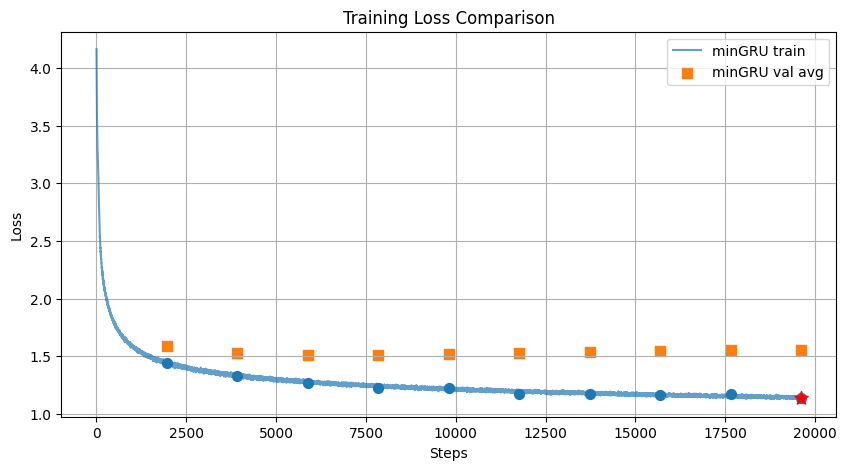

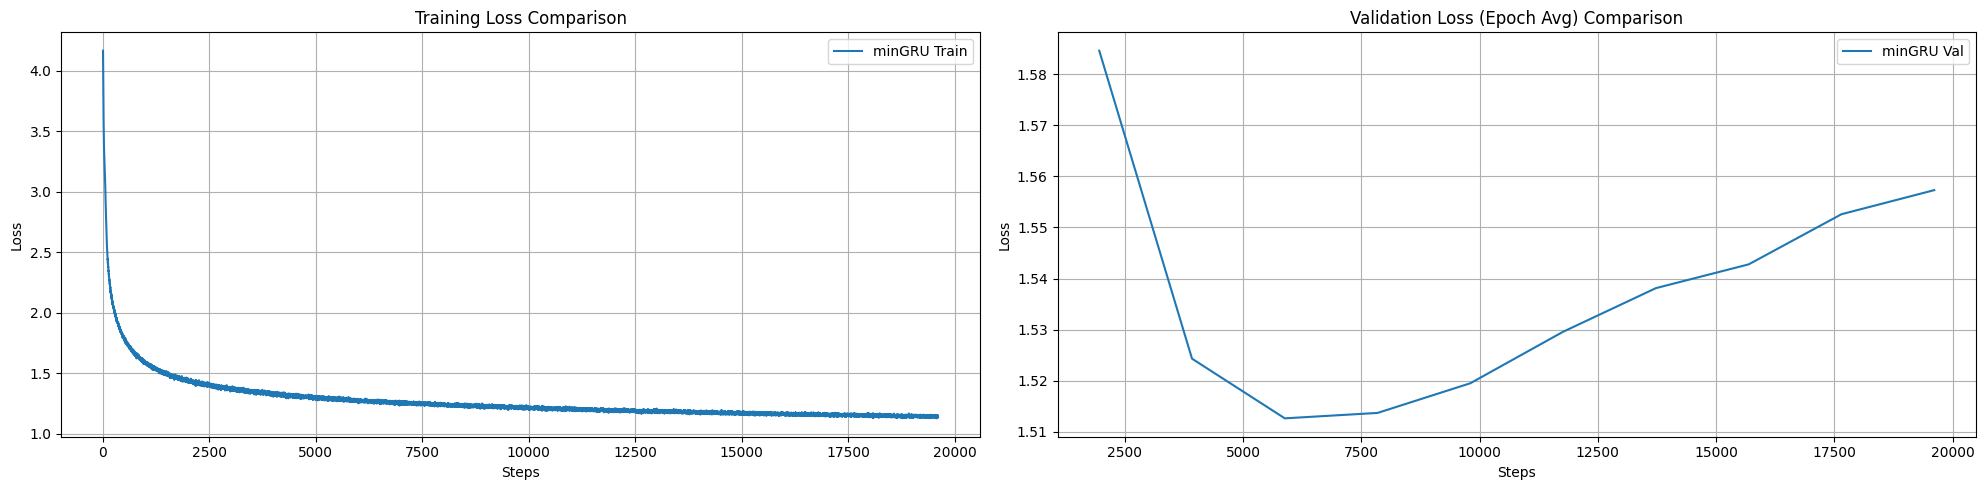

In [25]:
train_and_test("minGRU", mingru, start_text)

## mingru of cheind

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import abc
from typing import Final, List, Tuple, Optional

# --- Functional components for MinGRU (from cheind/mingru) ---

def _g_func(x: torch.Tensor) -> torch.Tensor:
    """Activation function for hidden state."""
    out = torch.empty_like(x)
    mask = x >= 0
    # Ensure 0.5 has the same dtype as x
    out[mask] = x[mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)
    out[~mask] = torch.sigmoid(x[~mask])
    return out

def _log_g_func(x: torch.Tensor) -> torch.Tensor:
    """Log-activation function for hidden state."""
    out = torch.empty_like(x) # out will have the same dtype as x (e.g., float16 under autocast)
    mask = x >= 0
    # Perform calculation and ensure result is cast back to x's dtype before assignment
    # (x[mask] + constant_of_x_dtype) results in x_dtype
    # .log() might upcast to float32 for precision
    # .to(x.dtype) casts it back to the original dtype for assignment
    out[mask] = (x[mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)).log().to(x.dtype)
    
    # Ensure the output of F.softplus is also cast to the correct dtype
    out[~mask] = (-F.softplus(-x[~mask])).to(x.dtype)
    return out

def _parallel_scan_log_func(log_a: torch.Tensor, log_b: torch.Tensor) -> torch.Tensor:
    """Parallel scan in log-space."""
    pad_dims = [0] * (log_a.ndim - 2) * 2 + [1, 0]
    a_star = F.pad(torch.cumsum(log_a, dim=1), pad_dims)
    
    # Placeholder for torch.logcumsumexp if not available in older PyTorch versions
    if not hasattr(torch, 'logcumsumexp'):
        def _logcumsumexp(x_val, dim_val):
            if x_val.ndim == 0: return x_val
            if x_val.shape[dim_val] == 0: return x_val
            elements = torch.unbind(x_val, dim=dim_val)
            out_elements = [elements[0]]
            current_log_sum_exp = elements[0]
            for i in range(1, len(elements)):
                m = torch.maximum(current_log_sum_exp, elements[i])
                current_log_sum_exp = m + torch.log1p(torch.exp(-torch.abs(current_log_sum_exp - elements[i])))
                out_elements.append(current_log_sum_exp)
            return torch.stack(out_elements, dim=dim_val)
        x0_plus_b_star = _logcumsumexp(log_b - a_star, dim=1)
    else:
        x0_plus_b_star = torch.logcumsumexp(log_b - a_star, dim=1)
    
    log_x = a_star + x0_plus_b_star
    return torch.exp(log_x)

def _mingru_parallel_func(h_prev_log: torch.Tensor, gate: torch.Tensor, hidden: torch.Tensor) -> torch.Tensor:
    """Parallel MinGRU forward computation."""
    log_z = -F.softplus(-gate)
    log_one_minus_z = -F.softplus(gate)
    log_tilde_h = _log_g_func(hidden) # `hidden` tensor's dtype will propagate into _log_g_func
    log_b_for_scan = torch.cat((h_prev_log, log_z + log_tilde_h), dim=1)
    h_sequence_plus_initial = _parallel_scan_log_func(log_one_minus_z, log_b_for_scan)
    return h_sequence_plus_initial[:, 1:]

def _mingru_gate_hidden_func(gate: torch.Tensor, hidden: torch.Tensor, h_prev: torch.Tensor) -> torch.Tensor:
    """Evaluate the MinGRU using the parallel approach."""
    # Ensure h_prev is positive before log. g_activation in init_hidden_state should handle this.
    # Adding epsilon for numerical stability, cast to h_prev's dtype.
    epsilon = torch.tensor(1e-12, dtype=h_prev.dtype, device=h_prev.device)
    log_h_prev = (h_prev + epsilon).log() 
    return _mingru_parallel_func(log_h_prev, gate, hidden)

class mF: # Simulated namespace to match the repository's structure
    g = _g_func
    mingru_gate_hidden = _mingru_gate_hidden_func

# --- MinGRU Base and Multi-layer MinGRU Class (from cheind/mingru) ---

class MinGRUBase(torch.nn.Module, metaclass=abc.ABCMeta):
    """Common base interface for all MinGRU implementations."""
    @abc.abstractmethod
    @torch.jit.export
    def init_hidden_state(self, x: torch.Tensor) -> List[torch.Tensor]:
        pass

    @abc.abstractmethod
    def forward(self, x: torch.Tensor, h: Optional[List[torch.Tensor]] = None) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        pass

class MinGRU(MinGRUBase):
    """A multi-layer minimal gated recurrent unit (MinGRU)."""
    layer_sizes: Final[Tuple[int, ...]]
    num_layers: Final[int]

    def __init__(
        self,
        input_size: int,
        hidden_sizes: List[int],
        *,
        bias: bool = True,
        norm: bool = False,
        dropout: float = 0.0,
        residual: bool = False,
        device: Optional[torch.device] = None,
        dtype: Optional[torch.dtype] = None,
    ):
        super().__init__()
        self.layer_sizes = tuple([input_size] + hidden_sizes)
        self.num_layers = len(hidden_sizes)
        self.dropout_p = dropout
        self.residual = residual
        self.use_internal_norm = norm
        
        layers = []
        factory_kwargs = {"device": device, "dtype": dtype}
        gen = zip(self.layer_sizes[:-1], self.layer_sizes[1:])
        for lidx, (ind, outd) in enumerate(gen):
            mdict = {}
            if self.use_internal_norm:
                mdict["norm"] = torch.nn.LayerNorm(ind, **factory_kwargs)
            else:
                mdict["norm"] = torch.nn.Identity()

            mdict["gate_hidden"] = torch.nn.Linear(ind, outd * 2, bias=bias, **factory_kwargs)
            mdict["res_align"] = torch.nn.Linear(ind, outd, bias=False, **factory_kwargs) if residual and ind != outd else torch.nn.Identity()
            mdict["dropout"] = torch.nn.Dropout(p=self.dropout_p) if self.dropout_p > 0.0 and lidx < (self.num_layers - 1) else torch.nn.Identity()
            layers.append(torch.nn.ModuleDict(mdict))
        self.layers = torch.nn.ModuleList(layers)

    def forward(
        self,
        x: torch.Tensor,
        h: Optional[List[torch.Tensor]] = None,
    ) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        assert (x.ndim == 3 and x.shape[2] == self.layer_sizes[0]), "x should be (B,S,input_size)"
        if h is None: h = self.init_hidden_state(x)

        inp = x
        next_hidden_states = []
        for lidx, layer_module_dict in enumerate(self.layers):
            norm_out = layer_module_dict.norm(inp)
            gate, hidden = layer_module_dict.gate_hidden(norm_out).chunk(2, dim=2)
            # h[lidx] is the specific hidden state for this layer
            out_sequence = mF.mingru_gate_hidden(gate, hidden, h[lidx])
            next_hidden_states.append(out_sequence[:, -1:]) # Get last time step for next hidden state
            
            if self.residual:
                # The residual should be added to the output of the GRU operation for this layer
                # inp is the input to this specific GRU layer
                out_sequence = out_sequence + layer_module_dict.res_align(inp) 
            
            inp = layer_module_dict.dropout(out_sequence) # Output of this layer becomes input to next
        return inp, next_hidden_states # inp is the output of the last layer

    @torch.jit.export
    def init_hidden_state(self, x: torch.Tensor) -> List[torch.Tensor]:
        # x is the initial input to the MinGRU module (B, S, input_size)
        # We need to initialize hidden states for each layer.
        initial_states = [mF.g(x.new_zeros(x.shape[0], 1, hs, dtype=x.dtype)) for hs in self.layer_sizes[1:]]
        return initial_states

# --- Standard Components for MinGRUDecoder2 ---
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.scale = dim ** -0.5
        self.eps = eps
        self.g = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        # Cast to float32 for norm calculation for stability, then cast back if needed.
        # This is a common practice with RMSNorm/LayerNorm when using float16.
        original_dtype = x.dtype
        x_float32 = x.to(torch.float32)
        norm_val = torch.norm(x_float32, dim=-1, keepdim=True) * self.scale
        normalized_x = x_float32 / norm_val.clamp(min=self.eps)
        return normalized_x.to(original_dtype) * self.g

class CausalDepthWiseConv1d(nn.Module):
    def __init__(self, dim, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim),
            nn.Conv1d(dim, dim, kernel_size=1)
        )
    def forward(self, x):
        x_transposed = x.transpose(1, 2)
        # Padding value should ideally match the distribution, but 0 is common.
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0), value=0.0)
        x_out = self.net(x_padded)
        return x_out.transpose(1, 2)

class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 2.0, dropout: float = 0.0):
        super().__init__()
        hidden_dim = int(dim * expansion_factor * (2/3))
        hidden_dim = (hidden_dim + 7) // 8 * 8
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(dim, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.act_fn = nn.SiLU()
    def forward(self, x):
        return self.dropout(self.w3(self.act_fn(self.w1(x)) * self.w2(x)))

class MinGRUDecoder2(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int = 2, # This now controls the depth of the MinGRU module
        dropout: float = 0.1,
        rms_norm_eps: float = 1e-8,
        enable_conv: bool = True,
        conv_kernel_size: int = 3,
        ffn_expansion_factor: float = 1.0
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_projection = nn.Linear(embedding_dim, hidden_dim) if embedding_dim != hidden_dim else nn.Identity()
        
        self.conv_block = CausalDepthWiseConv1d(hidden_dim, conv_kernel_size) if enable_conv else nn.Identity()
        
        self.norm_pre_gru = RMSNorm(hidden_dim, eps=rms_norm_eps)
        
        self.mingru_module = MinGRU(
            input_size=hidden_dim,
            hidden_sizes=[hidden_dim] * num_layers, # All internal layers have hidden_dim
            norm=False,  # MinGRUDecoder2 uses RMSNorm externally before MinGRU
            dropout=dropout, # Pass dropout to MinGRU for inter-layer dropout
            residual=True  # Enable internal residuals in MinGRU
        )
        
        self.norm_post_gru = RMSNorm(hidden_dim, eps=rms_norm_eps) # Norm after GRU block, before FFN
        self.ffn_module = SwiGLUFFN(dim=hidden_dim, expansion_factor=ffn_expansion_factor, dropout=dropout)
        
        self.final_norm = RMSNorm(hidden_dim, eps=rms_norm_eps)
        self.output_projection = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, None]:
        # 1. Input Embedding & Projection
        h = self.input_projection(self.embedding(x)) # (B, S, H)
        
        # 2. Convolutional Block (h_res_conv is h before conv)
        h_res_conv = h
        h_conv_out = self.conv_block(h_res_conv)
        h = h_res_conv + h_conv_out if isinstance(self.conv_block, CausalDepthWiseConv1d) else h_res_conv

        # 3. GRU Block (h_res_gru is h before GRU block)
        h_res_gru = h 
        h_gru_input = self.norm_pre_gru(h_res_gru)
        # MinGRU's forward expects initial hidden states or will create them.
        # It's better to explicitly create them based on the input to MinGRU.
        # The init_hidden_state method of MinGRU is designed for this.
        initial_mingru_h = self.mingru_module.init_hidden_state(h_gru_input)
        h_gru_out, _ = self.mingru_module(h_gru_input, h=initial_mingru_h) # h_gru_out is (B,S,H)
        h = h_res_gru + h_gru_out # Residual connection around GRU block (Norm -> MinGRU)

        # 4. FFN Block (h_res_ffn is h before FFN block)
        h_res_ffn = h
        h_ffn_input = self.norm_post_gru(h_res_ffn) # Norm output of GRU block
        h_ffn_out = self.ffn_module(h_ffn_input)
        h = h_res_ffn + h_ffn_out # Residual connection around FFN block (Norm -> FFN)
        
        # 5. Final Projection
        h_final = self.final_norm(h) # Norm before final linear layer
        logits = self.output_projection(h_final) # (B, S, V)
        
        return logits, None


In [27]:
### Model Initialization
mingru2 = MinGRUDecoder2(vocab_size, EMBEDDING_DIM, 316, NUM_LAYERS).to(device)

In [28]:
from torchinfo import summary

summary(mingru2, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
MinGRUDecoder2                           [512, 128, 65]            --
├─Embedding: 1-1                         [512, 128, 128]           8,320
├─Linear: 1-2                            [512, 128, 316]           40,764
├─CausalDepthWiseConv1d: 1-3             [512, 128, 316]           --
│    └─Sequential: 2-1                   [512, 316, 128]           --
│    │    └─Conv1d: 3-1                  [512, 316, 128]           1,264
│    │    └─Conv1d: 3-2                  [512, 316, 128]           100,172
├─RMSNorm: 1-4                           [512, 128, 316]           316
├─MinGRU: 1-5                            [512, 128, 316]           --
│    └─ModuleList: 2-2                   --                        --
│    │    └─ModuleDict: 3-3              --                        200,344
│    │    └─ModuleDict: 3-4              --                        200,344
│    │    └─ModuleDict: 3-5              --                

Epoch 1/10, Train Loss: 1.5046, Val Loss: 1.7569, Epoch Time: 239.37s Average Vram Usage: 48.09MB


Epoch 2/10, Train Loss: 1.3935, Val Loss: 1.6423, Epoch Time: 240.43s Average Vram Usage: 48.34MB


Epoch 3/10, Train Loss: 1.2896, Val Loss: 1.6175, Epoch Time: 240.11s Average Vram Usage: 48.05MB


Epoch 4/10, Train Loss: 1.2578, Val Loss: 1.6053, Epoch Time: 240.21s Average Vram Usage: 48.05MB


Epoch 5/10, Train Loss: 1.2396, Val Loss: 1.5969, Epoch Time: 240.67s Average Vram Usage: 48.05MB


Epoch 6/10, Train Loss: 1.2124, Val Loss: 1.5990, Epoch Time: 238.64s Average Vram Usage: 48.05MB


Epoch 7/10, Train Loss: 1.1878, Val Loss: 1.6081, Epoch Time: 238.01s Average Vram Usage: 48.05MB


Epoch 8/10, Train Loss: 1.1683, Val Loss: 1.6145, Epoch Time: 239.91s Average Vram Usage: 48.05MB


Epoch 9/10, Train Loss: 1.1744, Val Loss: 1.6347, Epoch Time: 240.03s Average Vram Usage: 48.05MB


Epoch 10/10, Train Loss: 1.1567, Val Loss: 1.6405, Epoch Time: 239.49s Average Vram Usage: 48.05MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And yo]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you are many pleasure. Thus he hath known
The torments of able condemned since forth
Having proud cousin Citizen:
He dreams, both with him! gracious late what think,
Speak with a fresh some house of her hour,
As four queen and slowed but great us.

JULIET:
No, having him to such sweet to have our lasting.

ANGELO:
Ay, a pitch.

WARWICK:
Are you have a ranco come to be,
Our voices fears and has mine eyes at the shade
I dare like uncurlongs with a child:
I now threaten them blessing adversed
With yo


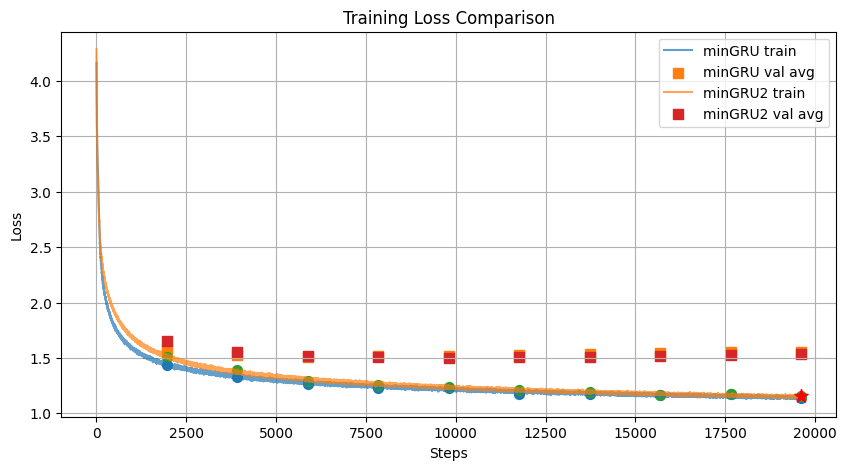

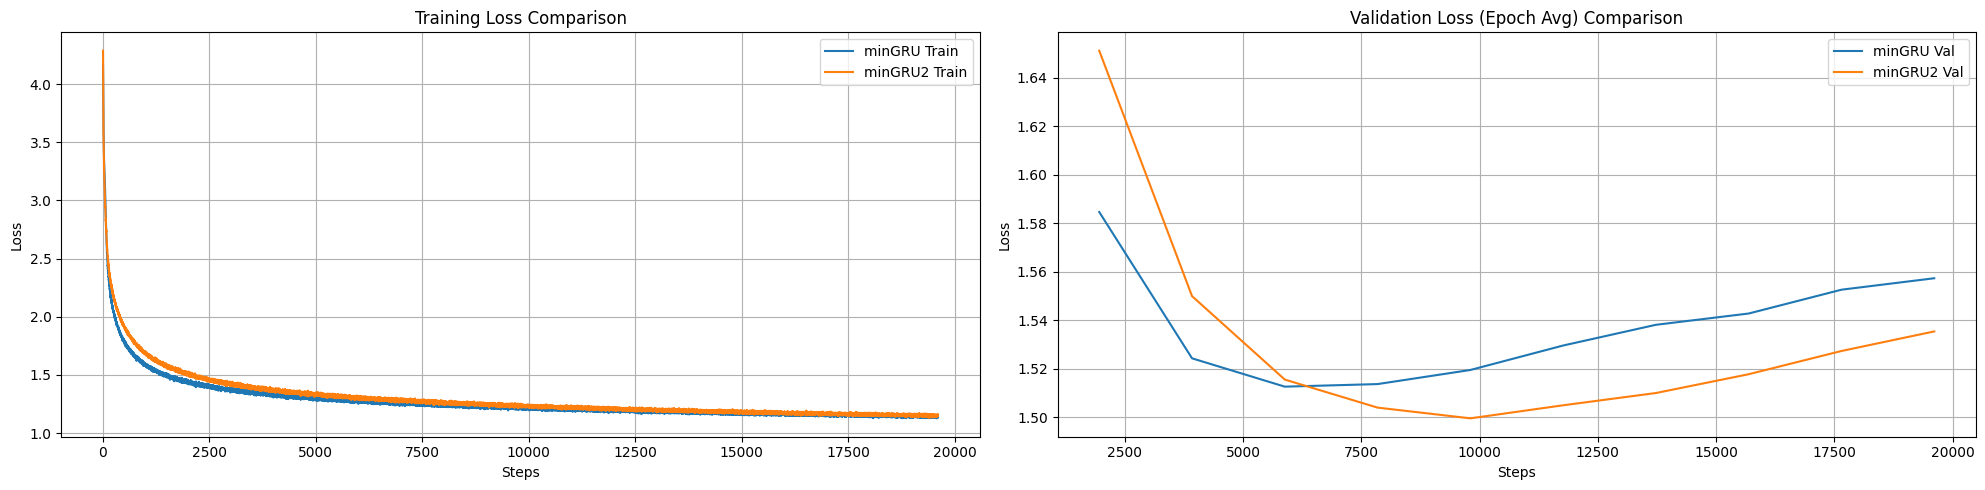

In [29]:
train_and_test("minGRU2", mingru2, start_text)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import abc
from typing import Final, List, Tuple, Optional

# --- Functional components for MinGRU (from cheind/mingru) ---

def _g_func(x: torch.Tensor) -> torch.Tensor:
    """Activation function for hidden state."""
    out = torch.empty_like(x)
    mask = x >= 0
    # Ensure 0.5 has the same dtype as x
    out[mask] = x[mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)
    out[~mask] = torch.sigmoid(x[~mask])
    return out

def _log_g_func(x: torch.Tensor) -> torch.Tensor:
    """Log-activation function for hidden state."""
    out = torch.empty_like(x) # out will have the same dtype as x (e.g., float16 under autocast)
    mask = x >= 0
    # Perform calculation and ensure result is cast back to x's dtype before assignment
    # (x[mask] + constant_of_x_dtype) results in x_dtype
    # .log() might upcast to float32 for precision
    # .to(x.dtype) casts it back to the original dtype for assignment
    out[mask] = (x[mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)).log().to(x.dtype)
    
    # Ensure the output of F.softplus is also cast to the correct dtype
    out[~mask] = (-F.softplus(-x[~mask])).to(x.dtype)
    return out

def _parallel_scan_log_func(log_a: torch.Tensor, log_b: torch.Tensor) -> torch.Tensor:
    """Parallel scan in log-space."""
    pad_dims = [0] * (log_a.ndim - 2) * 2 + [1, 0]
    a_star = F.pad(torch.cumsum(log_a, dim=1), pad_dims)
    
    # Placeholder for torch.logcumsumexp if not available in older PyTorch versions
    if not hasattr(torch, 'logcumsumexp'):
        def _logcumsumexp(x_val, dim_val):
            if x_val.ndim == 0: return x_val
            if x_val.shape[dim_val] == 0: return x_val
            elements = torch.unbind(x_val, dim=dim_val)
            out_elements = [elements[0]]
            current_log_sum_exp = elements[0]
            for i in range(1, len(elements)):
                m = torch.maximum(current_log_sum_exp, elements[i])
                current_log_sum_exp = m + torch.log1p(torch.exp(-torch.abs(current_log_sum_exp - elements[i])))
                out_elements.append(current_log_sum_exp)
            return torch.stack(out_elements, dim=dim_val)
        x0_plus_b_star = _logcumsumexp(log_b - a_star, dim=1)
    else:
        x0_plus_b_star = torch.logcumsumexp(log_b - a_star, dim=1)
    
    log_x = a_star + x0_plus_b_star
    return torch.exp(log_x)

def _mingru_parallel_func(h_prev_log: torch.Tensor, gate: torch.Tensor, hidden: torch.Tensor) -> torch.Tensor:
    """Parallel MinGRU forward computation."""
    log_z = -F.softplus(-gate)
    log_one_minus_z = -F.softplus(gate)
    log_tilde_h = _log_g_func(hidden) # `hidden` tensor's dtype will propagate into _log_g_func
    log_b_for_scan = torch.cat((h_prev_log, log_z + log_tilde_h), dim=1)
    h_sequence_plus_initial = _parallel_scan_log_func(log_one_minus_z, log_b_for_scan)
    return h_sequence_plus_initial[:, 1:]

def _mingru_gate_hidden_func(gate: torch.Tensor, hidden: torch.Tensor, h_prev: torch.Tensor) -> torch.Tensor:
    """Evaluate the MinGRU using the parallel approach."""
    # Ensure h_prev is positive before log. g_activation in init_hidden_state should handle this.
    # Adding epsilon for numerical stability, cast to h_prev's dtype.
    epsilon = torch.tensor(1e-12, dtype=h_prev.dtype, device=h_prev.device)
    log_h_prev = (h_prev + epsilon).log() 
    return _mingru_parallel_func(log_h_prev, gate, hidden)

class mF: # Simulated namespace to match the repository's structure
    g = _g_func
    mingru_gate_hidden = _mingru_gate_hidden_func

# --- MinGRU Base and Multi-layer MinGRU Class (from cheind/mingru) ---

class MinGRUBase(torch.nn.Module, metaclass=abc.ABCMeta):
    """Common base interface for all MinGRU implementations."""
    @abc.abstractmethod
    @torch.jit.export
    def init_hidden_state(self, x: torch.Tensor) -> List[torch.Tensor]:
        pass

    @abc.abstractmethod
    def forward(self, x: torch.Tensor, h: Optional[List[torch.Tensor]] = None) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        pass

class MinGRU(MinGRUBase):
    """A multi-layer minimal gated recurrent unit (MinGRU)."""
    layer_sizes: Final[Tuple[int, ...]] # Includes input_size as the first element
    num_layers: Final[int] # Number of actual GRU layers

    def __init__(
        self,
        input_size: int,
        hidden_sizes: List[int], # List of hidden_size for each GRU layer
        *,
        bias: bool = True,
        norm: bool = False,
        dropout: float = 0.0,
        residual: bool = False,
        device: Optional[torch.device] = None,
        dtype: Optional[torch.dtype] = None,
    ):
        super().__init__()
        # layer_sizes will be [input_size, hidden_sizes[0], hidden_sizes[1], ...]
        self.layer_sizes = tuple([input_size] + hidden_sizes)
        self.num_layers = len(hidden_sizes) # This is the actual number of GRU layers
        self.dropout_p = dropout
        self.residual = residual
        self.use_internal_norm = norm
        
        layers = []
        factory_kwargs = {"device": device, "dtype": dtype}
        # gen iterates from input_size to hidden_sizes[0], then hidden_sizes[0] to hidden_sizes[1], etc.
        gen = zip(self.layer_sizes[:-1], self.layer_sizes[1:])
        for lidx, (ind, outd) in enumerate(gen): # ind is input_dim to layer, outd is output_dim of layer
            mdict = {}
            if self.use_internal_norm:
                mdict["norm"] = torch.nn.LayerNorm(ind, **factory_kwargs)
            else:
                mdict["norm"] = torch.nn.Identity()

            mdict["gate_hidden"] = torch.nn.Linear(ind, outd * 2, bias=bias, **factory_kwargs)
            mdict["res_align"] = torch.nn.Linear(ind, outd, bias=False, **factory_kwargs) if residual and ind != outd else torch.nn.Identity()
            # Dropout is applied to the output of each layer except the last one within MinGRU
            mdict["dropout"] = torch.nn.Dropout(p=self.dropout_p) if self.dropout_p > 0.0 and lidx < (self.num_layers - 1) else torch.nn.Identity()
            layers.append(torch.nn.ModuleDict(mdict))
        self.layers = torch.nn.ModuleList(layers)

    def forward(
        self,
        x: torch.Tensor, # Input to the MinGRU module, shape (B, S, input_size)
        h: Optional[List[torch.Tensor]] = None, # List of hidden states, one for each layer
    ) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        # x.shape[2] should match self.layer_sizes[0] which is input_size for MinGRU
        assert (x.ndim == 3 and x.shape[2] == self.layer_sizes[0]), \
            f"MinGRU input x shape[2] ({x.shape[2]}) does not match its input_size ({self.layer_sizes[0]})"
        if h is None: h = self.init_hidden_state(x)
        assert len(h) == self.num_layers, \
            f"Number of initial hidden states ({len(h)}) must match number of MinGRU layers ({self.num_layers})"


        inp = x # Current input to a layer, starts with x
        next_hidden_states = []
        for lidx, layer_module_dict in enumerate(self.layers):
            # h[lidx] is the initial hidden state for the lidx-th GRU layer.
            # Its shape should be (B, 1, self.layer_sizes[lidx+1])
            # inp is the input sequence to this lidx-th GRU layer.
            # Its shape should be (B, S, self.layer_sizes[lidx])
            
            norm_out = layer_module_dict.norm(inp)
            gate, hidden = layer_module_dict.gate_hidden(norm_out).chunk(2, dim=2)
            
            out_sequence = mF.mingru_gate_hidden(gate, hidden, h[lidx])
            next_hidden_states.append(out_sequence[:, -1:]) 
            
            if self.residual:
                out_sequence = out_sequence + layer_module_dict.res_align(inp) 
            
            inp = layer_module_dict.dropout(out_sequence)
        return inp, next_hidden_states

    @torch.jit.export
    def init_hidden_state(self, x: torch.Tensor) -> List[torch.Tensor]:
        # x is the input to the entire MinGRU module (B, S, self.layer_sizes[0])
        # We need to initialize hidden states for each of the self.num_layers GRU layers.
        # The hidden size for the i-th GRU layer is self.layer_sizes[i+1]
        initial_states = [mF.g(x.new_zeros(x.shape[0], 1, self.layer_sizes[lidx+1], dtype=x.dtype)) for lidx in range(self.num_layers)]
        return initial_states

# --- Standard Components for MinGRUDecoder2 ---
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.scale = dim ** -0.5
        self.eps = eps
        self.g = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        original_dtype = x.dtype
        x_float32 = x.to(torch.float32)
        norm_val = torch.norm(x_float32, dim=-1, keepdim=True) * self.scale
        normalized_x = x_float32 / norm_val.clamp(min=self.eps)
        return normalized_x.to(original_dtype) * self.g

class CausalDepthWiseConv1d(nn.Module):
    def __init__(self, dim, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim),
            nn.Conv1d(dim, dim, kernel_size=1)
        )
    def forward(self, x):
        x_transposed = x.transpose(1, 2)
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0), value=0.0)
        x_out = self.net(x_padded)
        return x_out.transpose(1, 2)

class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 2.0, dropout: float = 0.0):
        super().__init__()
        hidden_dim_ffn = int(dim * expansion_factor * (2/3))
        hidden_dim_ffn = (hidden_dim_ffn + 7) // 8 * 8
        self.w1 = nn.Linear(dim, hidden_dim_ffn, bias=False)
        self.w2 = nn.Linear(dim, hidden_dim_ffn, bias=False)
        self.w3 = nn.Linear(hidden_dim_ffn, dim, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.act_fn = nn.SiLU()
    def forward(self, x):
        return self.dropout(self.w3(self.act_fn(self.w1(x)) * self.w2(x)))

# --- Reconstructed MinGRUDecoder2 ---
class MinGRUDecoder3(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        # hidden_dim is now the input dimension to the first MinGRU layer
        # and the output dimension of the last MinGRU layer for consistency
        # with other modules in MinGRUDecoder2.
        # MinGRU's internal hidden_sizes can vary.
        mingru_input_hidden_dim: int, 
        mingru_internal_hidden_sizes: List[int], # List of hidden sizes for each MinGRU layer
        dropout: float = 0.1,
        rms_norm_eps: float = 1e-8,
        enable_conv: bool = True,
        conv_kernel_size: int = 3,
        ffn_expansion_factor: float = 1.0
    ):
        super().__init__()
        
        # The overall hidden_dim for MinGRUDecoder2 components (Conv, Norms, FFN)
        # will be based on the output of the MinGRU stack.
        # If mingru_internal_hidden_sizes is empty, it implies num_layers = 0 for MinGRU,
        # which is not typical. We assume mingru_internal_hidden_sizes is not empty.
        # The input to the first MinGRU layer is mingru_input_hidden_dim.
        # The output of the last MinGRU layer is mingru_internal_hidden_sizes[-1].
        # This final output dimension will be used for subsequent RMSNorm and FFN.
        
        if not mingru_internal_hidden_sizes:
            raise ValueError("mingru_internal_hidden_sizes list cannot be empty.")
            
        self.final_mingru_output_dim = mingru_internal_hidden_sizes[-1]

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Input projection projects embedding_dim to the input_dim of the first MinGRU layer
        self.input_projection = nn.Linear(embedding_dim, mingru_input_hidden_dim) if embedding_dim != mingru_input_hidden_dim else nn.Identity()
        
        self.conv_block = CausalDepthWiseConv1d(mingru_input_hidden_dim, conv_kernel_size) if enable_conv else nn.Identity()
        
        # Norm before MinGRU operates on mingru_input_hidden_dim
        self.norm_pre_gru = RMSNorm(mingru_input_hidden_dim, eps=rms_norm_eps)
        
        self.mingru_module = MinGRU(
            input_size=mingru_input_hidden_dim, # Input to the MinGRU stack
            hidden_sizes=mingru_internal_hidden_sizes, # List of hidden sizes for each layer
            norm=False,
            dropout=dropout,
            residual=True
        )
        
        # Norm after MinGRU and FFN operate on the output dimension of the last MinGRU layer
        self.norm_post_gru = RMSNorm(self.final_mingru_output_dim, eps=rms_norm_eps)
        self.ffn_module = SwiGLUFFN(dim=self.final_mingru_output_dim, expansion_factor=ffn_expansion_factor, dropout=dropout)
        
        self.final_norm = RMSNorm(self.final_mingru_output_dim, eps=rms_norm_eps)
        self.output_projection = nn.Linear(self.final_mingru_output_dim, vocab_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, None]:
        # 1. Input Embedding & Projection
        h = self.input_projection(self.embedding(x)) 
        
        # 2. Convolutional Block
        h_res_conv = h
        h_conv_out = self.conv_block(h_res_conv)
        h = h_res_conv + h_conv_out if isinstance(self.conv_block, CausalDepthWiseConv1d) else h_res_conv

        # 3. GRU Block
        h_res_gru = h 
        h_gru_input = self.norm_pre_gru(h_res_gru)
        initial_mingru_h = self.mingru_module.init_hidden_state(h_gru_input)
        h_gru_out, _ = self.mingru_module(h_gru_input, h=initial_mingru_h)
        # The residual for the GRU block should connect inputs and outputs of compatible dimensions.
        # If mingru_input_hidden_dim != final_mingru_output_dim, a simple sum is not possible
        # without a projection. The MinGRU module itself has internal residuals.
        # For the outer residual, we assume the input to the block (h_res_gru)
        # has the same dimension as the output of the MinGRU stack (h_gru_out) if a residual
        # is applied here.
        # If dimensions differ, this residual needs adjustment or removal.
        # For now, let's assume the MinGRU module handles its dimensionality changes and
        # the outer residual connects the input to the *GRU block* (h_res_gru) with the
        # output of the *GRU module* (h_gru_out). This requires h_res_gru and h_gru_out
        # to have the same dimension, meaning mingru_input_hidden_dim == final_mingru_output_dim.
        
        # If mingru_input_hidden_dim == self.final_mingru_output_dim:
        if h_res_gru.shape[-1] == h_gru_out.shape[-1]:
             h = h_res_gru + h_gru_out
        else:
            # If dimensions don't match, we cannot directly add.
            # Option 1: Project h_res_gru to match h_gru_out.shape[-1]
            # Option 2: Do not apply this outer residual, rely on MinGRU's internal residuals.
            # For simplicity, if they don't match, we just take the output of MinGRU.
            # This implies the MinGRU block is responsible for its full transformation.
            print(f"Warning: Dimensions mismatch for GRU block residual. Input: {h_res_gru.shape[-1]}, Output: {h_gru_out.shape[-1]}. Skipping outer residual for GRU block.")
            h = h_gru_out


        # 4. FFN Block
        h_res_ffn = h # Input to the FFN block
        h_ffn_input = self.norm_post_gru(h_res_ffn)
        h_ffn_out = self.ffn_module(h_ffn_input)
        h = h_res_ffn + h_ffn_out
        
        # 5. Final Projection
        h_final = self.final_norm(h)
        logits = self.output_projection(h_final)
        
        return logits, None


In [31]:
### Model Initialization
mingru3 = MinGRUDecoder3(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, [HIDDEN_DIM, 384, HIDDEN_DIM], 0.1).to(device)

In [32]:
from torchinfo import summary

summary(mingru3, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
MinGRUDecoder3                           [512, 128, 65]            --
├─Embedding: 1-1                         [512, 128, 128]           8,320
├─Linear: 1-2                            [512, 128, 256]           33,024
├─CausalDepthWiseConv1d: 1-3             [512, 128, 256]           --
│    └─Sequential: 2-1                   [512, 256, 128]           --
│    │    └─Conv1d: 3-1                  [512, 256, 128]           1,024
│    │    └─Conv1d: 3-2                  [512, 256, 128]           65,792
├─RMSNorm: 1-4                           [512, 128, 256]           256
├─MinGRU: 1-5                            [512, 128, 256]           --
│    └─ModuleList: 2-2                   --                        --
│    │    └─ModuleDict: 3-3              --                        131,584
│    │    └─ModuleDict: 3-4              --                        295,680
│    │    └─ModuleDict: 3-5              --                 

In [ ]:
train_and_test("minGRU3", mingru3, start_text)

Epoch 1/10, Train Loss: 1.4137, Val Loss: 1.6368, Epoch Time: 219.78s Average Vram Usage: 55.59MB


Epoch 2/10, Train Loss: 1.2944, Val Loss: 1.5645, Epoch Time: 217.57s Average Vram Usage: 55.59MB


Epoch 3/10, Train Loss: 1.2520, Val Loss: 1.5444, Epoch Time: 218.76s Average Vram Usage: 55.59MB


Epoch 4/10, Train Loss: 1.2035, Val Loss: 1.5866, Epoch Time: 220.44s Average Vram Usage: 55.59MB


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import abc
from typing import Final, List, Tuple, Optional, Union


from torch.nn import RMSNorm

class CausalDepthWiseConv1d(nn.Module):
    # 인과적(Causal) 1D Depth-wise 컨볼루션
    def __init__(self, dim, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim), # Depthwise
            nn.Conv1d(dim, dim, kernel_size=1)                       # Pointwise
        )
    def forward(self, x): # 입력: (B, L, C)
        x_transposed = x.transpose(1, 2) # (B, C, L)
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0))
        x_out = self.net(x_padded)
        return x_out.transpose(1, 2) # 출력: (B, L, C)


# --- MinGRU 핵심 기능 (mF 네임스페이스) ---
# @torch.jit.script # JIT 컴파일 시도 가능
class mF:
    @staticmethod
    def g(x: torch.Tensor) -> torch.Tensor:
        out = torch.empty_like(x)
        mask = x >= 0
        out[mask] = x[mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)
        out[~mask] = torch.sigmoid(x[~mask])
        return out

    @staticmethod
    def log_g(x: torch.Tensor) -> torch.Tensor:
        out = torch.empty_like(x)
        mask = x >= 0
        out[mask] = (x[mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)).log().to(x.dtype)
        out[~mask] = (-F.softplus(-x[~mask])).to(x.dtype)
        return out

    @staticmethod
    def _parallel_scan_log(log_a: torch.Tensor, log_b: torch.Tensor) -> torch.Tensor:
        pad_dims = [0] * (log_a.ndim - 2) * 2 + [1, 0]
        a_star = F.pad(torch.cumsum(log_a, dim=1), pad_dims)
        x0_plus_b_star = torch.logcumsumexp(log_b - a_star, dim=1)
        
        log_x = a_star + x0_plus_b_star
        return torch.exp(log_x)

    @staticmethod
    def _mingru_parallel(h_prev_log: torch.Tensor, gate: torch.Tensor, hidden: torch.Tensor) -> torch.Tensor:
        log_z = -F.softplus(-gate)
        log_one_minus_z = -F.softplus(gate)
        log_tilde_h = mF.log_g(hidden)
        log_b_for_scan = torch.cat((h_prev_log, log_z + log_tilde_h), dim=1)
        h_sequence_plus_initial = mF._parallel_scan_log(log_one_minus_z, log_b_for_scan)
        return h_sequence_plus_initial[:, 1:]

    @staticmethod
    def mingru_gate_hidden(gate: torch.Tensor, hidden: torch.Tensor, h_prev: torch.Tensor) -> torch.Tensor:
        epsilon = torch.tensor(1e-12, dtype=h_prev.dtype, device=h_prev.device)
        log_h_prev = (h_prev + epsilon).log()
        return mF._mingru_parallel(log_h_prev, gate, hidden)

# --- MinGRU 모듈 (cheind/mingru 기반) ---
# @torch.jit.script # JIT 컴파일 시도 가능 (MinGRUBase 상속 문제 해결 필요)
class MinGRU(nn.Module): # MinGRUBase 대신 nn.Module 직접 상속 (JIT 호환성 위함)
    layer_sizes: Tuple[int, ...] # Final 제거 (JIT 호환성)
    num_layers: int # Final 제거

    def __init__(
        self,
        input_size: int,
        hidden_sizes: List[int],
        bias: bool = True, # 명시적 파라미터 (기존 * 제거)
        norm: bool = False,
        dropout: float = 0.0,
        residual: bool = False,
    ):
        super().__init__()
        self.layer_sizes = tuple([input_size] + hidden_sizes)
        self.num_layers = len(hidden_sizes)
        self.dropout_p = dropout
        self.residual = residual
        self.use_internal_norm = norm
        
        layers_list = [] # ModuleList 사용
        gen = zip(self.layer_sizes[:-1], self.layer_sizes[1:])
        for lidx, (ind, outd) in enumerate(gen):
            layer_modules = {} # 일반 dict 사용
            if self.use_internal_norm:
                layer_modules["norm"] = torch.nn.LayerNorm(ind)
            else:
                layer_modules["norm"] = torch.nn.Identity()

            layer_modules["gate_hidden"] = torch.nn.Linear(ind, outd * 2, bias=bias)
            layer_modules["res_align"] = torch.nn.Linear(ind, outd, bias=False) if residual and ind != outd else torch.nn.Identity()
            layer_modules["dropout"] = torch.nn.Dropout(p=self.dropout_p) if self.dropout_p > 0.0 and lidx < (self.num_layers - 1) else torch.nn.Identity()
            layers_list.append(torch.nn.ModuleDict(layer_modules)) # ModuleDict를 리스트에 추가
        self.layers = torch.nn.ModuleList(layers_list) # ModuleList로 변환

    # @torch.jit.export # JIT 사용 시 init_hidden_state도 JIT 호환되어야 함
    def init_hidden_state(self, x: torch.Tensor) -> List[torch.Tensor]:
        return [mF.g(x.new_zeros(x.shape[0], 1, hs, dtype=x.dtype)) for hs in self.layer_sizes[1:]]

    def forward(
        self,
        x: torch.Tensor,
        h: Optional[List[torch.Tensor]] = None,
    ) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        if h is None: h = self.init_hidden_state(x)
        
        inp = x
        next_hidden_states: List[torch.Tensor] = [] # 타입 명시
        for lidx in range(self.num_layers): # ModuleList는 직접 인덱싱 또는 이터레이션
            layer_module_dict = self.layers[lidx]
            norm_out = layer_module_dict["norm"](inp)
            gate, hidden = layer_module_dict["gate_hidden"](norm_out).chunk(2, dim=2)
            
            current_h: torch.Tensor = h[lidx] # 타입 명시
            out_sequence = mF.mingru_gate_hidden(gate, hidden, current_h)
            next_hidden_states.append(out_sequence[:, -1:])
            
            if self.residual:
                out_sequence = out_sequence + layer_module_dict["res_align"](inp)
            inp = layer_module_dict["dropout"](out_sequence)
        return inp, next_hidden_states


# --- SwiGLUFFN (변경 없음) ---
class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 2.0, dropout: float = 0.0):
        super().__init__()
        hidden_dim = int(dim * expansion_factor * (2/3))
        hidden_dim = (hidden_dim + 7) // 8 * 8
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(dim, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.act_fn = nn.SiLU()
    def forward(self, x):
        return self.dropout(self.w3(self.act_fn(self.w1(x)) * self.w2(x)))

# @torch.jit.script # JIT 컴파일 시도 가능
class MinGRUDecoder4(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: Union[int, List[int]],
        num_layers: Optional[int] = None,
        dropout: float = 0.1,
        rms_norm_eps: float = 1e-8,
        enable_conv: bool = True,
        conv_kernel_size: int = 3,
        ffn_expansion_factor: float = 1.0
    ):
        super().__init__()
        
        if isinstance(hidden_dim, int):
            if num_layers is None or num_layers < 1: raise ValueError("`num_layers`는 양의 정수여야 합니다.")
            mingru_internal_sizes = [hidden_dim] * num_layers
        elif isinstance(hidden_dim, list):
            if not hidden_dim: raise ValueError("`hidden_dim` 리스트는 비어있을 수 없습니다.")
            mingru_internal_sizes = hidden_dim
        else:
            raise TypeError("`hidden_dim`은 정수 또는 정수 리스트여야 합니다.")
        
        mingru_input_dim = mingru_internal_sizes[0]
        mingru_output_dim = mingru_internal_sizes[-1]
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_projection = nn.Linear(embedding_dim, mingru_input_dim) if embedding_dim != mingru_input_dim else nn.Identity()
        self.conv_block = CausalDepthWiseConv1d(mingru_input_dim, conv_kernel_size) if enable_conv else nn.Identity()
        
        self.norm_pre_gru = RMSNorm(mingru_input_dim, eps=rms_norm_eps)
        
        self.mingru_module = MinGRU(
            input_size=mingru_input_dim,
            hidden_sizes=mingru_internal_sizes,
            # norm=False, # MinGRU 내부 LayerNorm 비활성화 (외부 RMSNorm 사용)
            dropout=dropout, 
            residual=True
        )
        self.gru_residual_projection = nn.Linear(mingru_input_dim, mingru_output_dim) if mingru_input_dim != mingru_output_dim else nn.Identity()

        self.norm_post_gru = RMSNorm(mingru_output_dim, eps=rms_norm_eps)
        self.ffn_module = SwiGLUFFN(dim=mingru_output_dim, expansion_factor=ffn_expansion_factor, dropout=dropout)
        self.final_norm = RMSNorm(mingru_output_dim, eps=rms_norm_eps)
        self.output_projection = nn.Linear(mingru_output_dim, vocab_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, None]:
        h = self.input_projection(self.embedding(x))
        
        h_res_conv = h
        if not isinstance(self.conv_block, nn.Identity): # nn.Identity가 아닐 때만 연산
            h = h_res_conv + self.conv_block(h_res_conv)

        h_res_gru = h
        h_gru_input = self.norm_pre_gru(h_res_gru)
        h_gru_out, _ = self.mingru_module(h_gru_input)
        h = self.gru_residual_projection(h_res_gru) + h_gru_out

        h_res_ffn = h
        h_ffn_input = self.norm_post_gru(h_res_ffn)
        h = h_res_ffn + self.ffn_module(h_ffn_input)
        
        h_final = self.final_norm(h)
        logits = self.output_projection(h_final)
        
        return logits, None

In [ ]:
### Model Initialization
mingru4 = MinGRUDecoder2(vocab_size, EMBEDDING_DIM, 316, NUM_LAYERS).to(device)

In [ ]:
from torchinfo import summary

summary(mingru4, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
MinGRUDecoder2                           [512, 128, 65]            --
├─Embedding: 1-1                         [512, 128, 128]           8,320
├─Linear: 1-2                            [512, 128, 316]           40,764
├─CausalDepthWiseConv1d: 1-3             [512, 128, 316]           --
│    └─Sequential: 2-1                   [512, 316, 128]           --
│    │    └─Conv1d: 3-1                  [512, 316, 128]           1,264
│    │    └─Conv1d: 3-2                  [512, 316, 128]           100,172
├─RMSNorm: 1-4                           [512, 128, 316]           316
├─MinGRU: 1-5                            [512, 128, 316]           --
│    └─ModuleList: 2-2                   --                        --
│    │    └─ModuleDict: 3-3              --                        200,344
│    │    └─ModuleDict: 3-4              --                        200,344
│    │    └─ModuleDict: 3-5              --                

Epoch 1/5, Train Loss: 1.5013, Val Loss: 1.6969, Epoch Time: 239.55s Average Vram Usage: 141.14MB


Epoch 2/5, Train Loss: 1.3825, Val Loss: 1.6538, Epoch Time: 239.83s Average Vram Usage: 141.03MB


Epoch 3/5, Train Loss: 1.3275, Val Loss: 1.6081, Epoch Time: 238.20s Average Vram Usage: 140.95MB


Epoch 4/5, Train Loss: 1.2755, Val Loss: 1.6058, Epoch Time: 240.70s Average Vram Usage: 140.83MB


Epoch 5/5, Train Loss: 1.2418, Val Loss: 1.5870, Epoch Time: 239.84s Average Vram Usage: 140.83MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And yo]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you depart! Come, my lord.

AUTOLYCUS:
I year, and when thou shalt mave,
O, penty blood honour,, brows: news, amen! the partner spoke apoken
Wrect my head which they say thou art permit him.

LEONTES:
Draw,
I do dept you a man help him our father of faults,
Where letters the state bed absence,
And kingly had things be and humble wonder:
There need would not the burn to you are a woman's,
As if that I did not show untake your hands.

LADY GREY:
If yet such lies more mislead,--

POMPEY:
You call thy


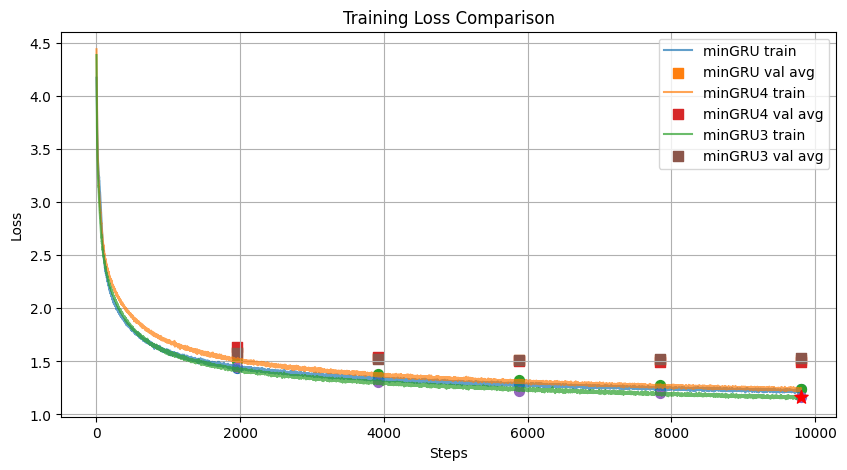

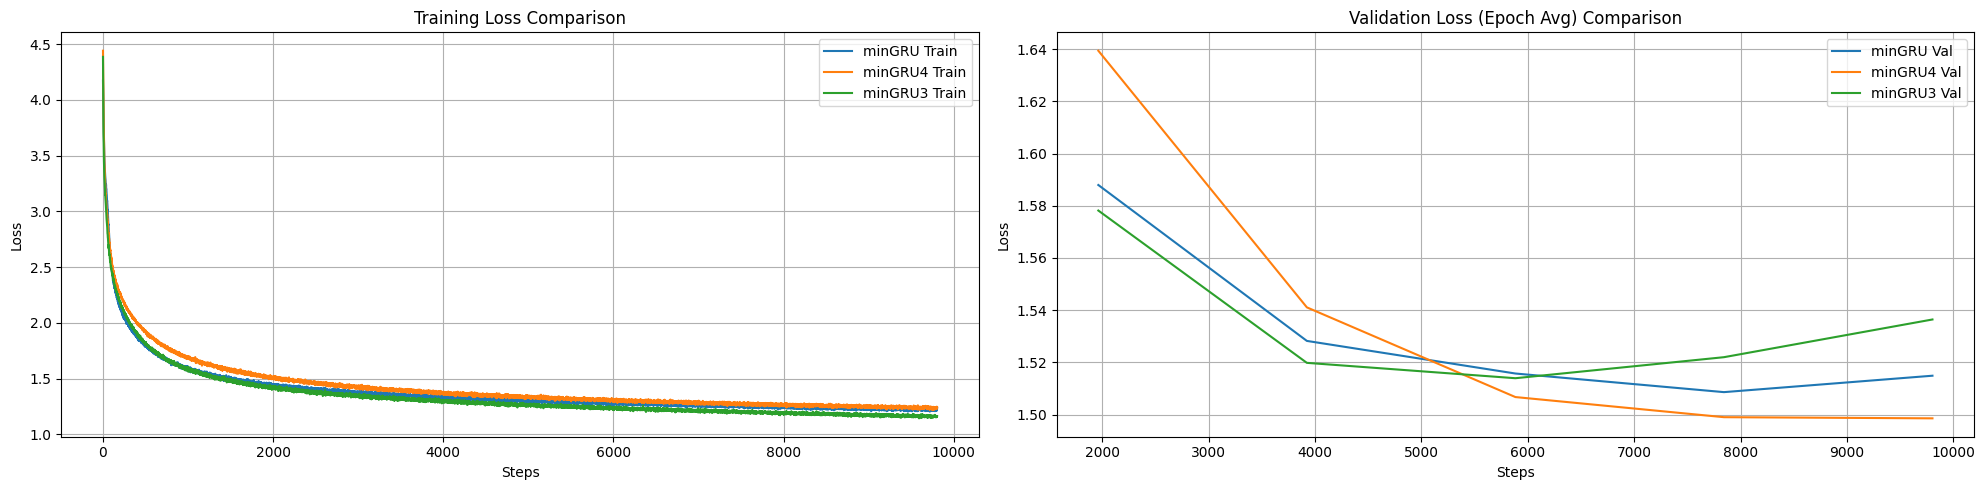

In [ ]:
train_and_test("minGRU4", mingru4, start_text)